In [ ]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import matplotlib.pyplot as plt
import molpot as mpot
from torch.distributions import Normal
N = 2000  # ideal gas particles in the box
kbT = 1.0
dt = 1.e-3
mass = 1.
box = 1.

In [1]:
class MonotonicInterpolate(nn.Module):
    """
    Piecewise cubic, monotonic interpolation via Steffens method [1].

    The interpolation curve is monotonic within each interval such that extrema
    can only occur at grid points. Guarantees continuous first derivatives
    of the spline. Is applicable to arbitrary data; not restricted to monotonic data.
    Contributed by Paul Fuchs.
    [1] Steffen, M., “A simple method for monotonic interpolation in one dimension.”,
    <i>Astronomy and Astrophysics</i>, vol. 239, pp. 443-450, 1990.

    Attributes:
        a, b, c, d: Piecewise coefficients for the cubic sections
        x: grid points

    Args:
        x : x-value of grid points -- must be strictly increasing
        y : y-value of grid points
        coefficients: Necessary for tree_unflatten

    Returns:
        A function that takes x values and returns spline values at these points
    """

    in_keys = ["atoms", "R"]
    out_keys = ["predicts", "spline_energy"]

    def __init__(self, x, y, coefficients=None):

        assert len(x) > 3, "Not enough input values for spline"
        assert len(x) == len(y), "x and y must have the same length"
        assert x.ndim == 1 and y.ndim == 1, "Input arrays must be 1D."

        if coefficients is None:

            h = torch.diff(x)
            k = torch.diff(y)
            s = k / h
            p = (s[0:-1] * h[1:] + s[1:] * h[0:-1]) / (h[0:-1] + h[1:])

            # Build coefficient pairs
            s0s1 = s[0:-1] * s[1:]
            a = torch.sign(s[0:-1])
            cond1 = torch.logical_or(
                torch.abs(p) > 2 * torch.abs(s[0:-1]),
                torch.abs(p) > 2 * torch.abs(s[1:]),
            )
            tmp = torch.where(
                cond1,
                2
                * a
                * torch.where(
                    torch.abs(s[0:1]) > torch.abs(s[1:]),
                    torch.abs(s[1:]),
                    torch.abs(s[0:-1]),
                ),
                p,
            )
            slopes = torch.where(s0s1 <= 0, 0.0, tmp)

            p0 = s[0] * (1 + h[0] / (h[0] + h[1])) - s[1] * (h[0] / (h[0] + h[1]))
            pn = s[-1] * (1 + h[-1] / (h[-1] + h[-2])) - s[-2] * (
                h[-1] / (h[-1] + h[-2])
            )

            tmp0 = torch.where(torch.abs(p0) > 2 * torch.abs(s[0]), 2 * s[0], p0)
            tmpn = torch.where(torch.abs(pn) > 2 * torch.abs(s[-1]), 2 * s[-1], pn)

            yp0 = torch.where(p0 * s[0] <= 0.0, 0.0, tmp0)
            ypn = torch.where(pn * s[-1] <= 0.0, 0.0, tmpn)
            slopes = torch.concatenate([torch.atleast_1d(yp0), torch.atleast_1d(slopes), torch.atleast_1d(ypn)])

            # Build the coefficients and store properties
            a = (slopes[0:-1] + slopes[1:] - 2 * s) / torch.square(h)
            b = (3 * s - 2 * slopes[0:-1] - slopes[1:]) / h
            c = slopes
            d = y[0:-1]

            coefficients = (a, b, c, d)

        self.x = x
        self.y = y
        self.coefficients = coefficients

    def forward(self, R):
        """
        Evaluate spline at new data points.

        Args:
            x_new: Evaluation points

        Returns:
            Returns the interpolated values y_new corresponding to y_new.
        """
        x_new = R
        a, b, c, d = self.coefficients

        x_new_idx = (
            torch.searchsorted(self.x, x_new, side="right") - 1
        )  # Find the indexes of the reference

        # avoid out of bound indexing
        x_new_idx = torch.where(x_new_idx < 0, 0, x_new_idx)
        x_new_idx = torch.where(x_new_idx > len(self.x) - 2, len(self.x) - 2, x_new_idx)

        # Return the interpolated values
        a = a[x_new_idx]
        b = b[x_new_idx]
        c = c[x_new_idx]
        d = d[x_new_idx]

        x = self.x[x_new_idx]
        y_new = (
            a * torch.power(x_new - x, 3)
            + b * torch.power(x_new - x, 2)
            + c * (x_new - x)
            + d
        )
        return y_new


class SingleWell(nn.Module):

    in_keys = ["atoms", "R"]
    out_keys = ["predicts", "prior_energy"]

    def __init__(self):
        super().__init__()

        self._lambda = torch.nn.Parameter(torch.tensor(75.0))

    def forward(self, R):
        return self._lambda * (R - 0.5) ** 2


def double_well(x):
    return kbT * (2500 * (x - 0.5) ** 6 - 10 * (x - 0.55) ** 2)


class DoubleWell(nn.Module):

    def forward(self, frame):
        x = frame["atoms", "R"]
        energy = double_well(x).sum()
        frame["predicts", "energy"] = energy
        frame["predicts", "forces"] = -torch.autograd.grad(energy, x)[0]
        return frame

NameError: name 'nn' is not defined

In [ ]:
# preview

def plot_1d_over_x(x, z, x_label=None, y_label=None, ylim=None):
    fig, ax = plt.subplots()
    ax.plot(x, z, color='#3c5488ff')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(ylim)
    ax.set_xlim([-0.1, box+0.1])
    plt.show()
    return fig, ax

resolution = 100
x_vals = torch.linspace(0.0, box, resolution + 1)
dx_bin = x_vals[1] - x_vals[0]
fig, ax = plot_1d_over_x(
    x_vals, double_well(x_vals), x_label="$x / L$", y_label="$U / k_B T$", ylim=[-1, 2]
)
sc = ax.scatter([], [])

In [ ]:
# define MD
x = torch.rand(N, 1, requires_grad=True) * box
R = torch.zeros(N, 3)
R[:, 0] = x.squeeze()
frame = mpot.Frame({"atoms": {"R": R, "mass": torch.ones(N, 1) * mass, "velocity": torch.zeros(N, 3)}})

ref_pot = DoubleWell()

md = mpot.MoleculeDymanics()
md.set_potential(ref_pot)
md.add_handler(mpot.md.UniformTemperature(T=1.0))
md.add_handler(mpot.md.VelocityVerlet(time_step=dt))
md.add_handler(mpot.md.Langevin(temperature=20., time_constant=10))
md.add_handler(mpot.md.Thermo(10000, "etotal"))
md.add_handler(
    mpot.md.ThermoOutput(10000, "etotal")
)  # dump to label

md_gen = mpot.pipeline.MDDataset(md)
frames = md_gen.prepare(frame, steps=10000, every=100, after=1000)


Output()

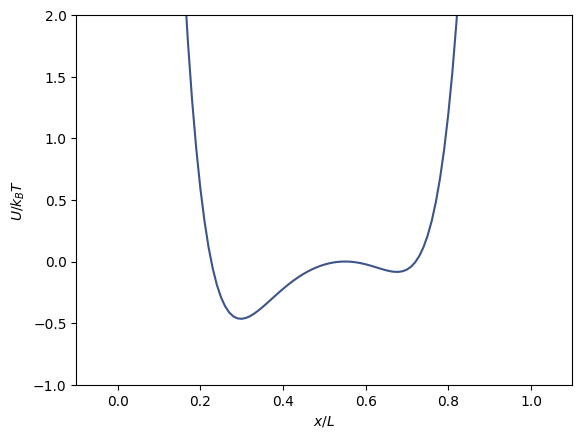

KeyboardInterrupt: 

In [ ]:
from matplotlib import animation
from IPython.display import HTML
import numpy as np


def update(i):

    R = frames[i]["atoms", "R"].detach().numpy()[:, 0]
    E = double_well(R)
    sc.set_offsets(np.stack([R, E]).T)
    return sc,

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=200, blit=True)
HTML(ani.to_jshtml())

In [ ]:
def init_normalized_density_fn(x_vals, dx_bin):
    def normalized_density(R):
        _R = R.reshape(-1, 1)
        norm = Normal(_R, dx_bin)
        pdf_vals = torch.exp(norm.log_prob(x_vals))
        return torch.mean(pdf_vals, axis=0)
    return normalized_density

normalized_density_fn = init_normalized_density_fn(x_vals, dx_bin)

def compute_quantity_traj(frames, quantity_fn):

    """
    Compute a quantity over the trajectory
    Args:
        frames: trajectory frames
        quantity_fn: function to compute the quantity
    Returns:
        The computed quantity
    """
    Rs = torch.stack([frame["atoms", "R"] for frame in frames])
    pdf_vals = []
    for i in range(len(Rs)):
        pdf_vals.append(quantity_fn(Rs[i]))

    pdf_vals = torch.mean(pdf_vals, axis=0)
    return pdf_vals

target_density = compute_quantity_traj(frames, normalized_density_fn)

plot_1d_over_x(
    x_vals,
    target_density.detach().numpy() ,
    x_label="$x / L$",
    y_label="Density"
)

: 

In [ ]:
# define model
spline_grid = torch.linspace(0.0, 1.0, 50)
init_params = 0.01 * torch.randn(len(spline_grid))
spline = MonotonicInterpolate(spline_grid, init_params)  # U_model
prior = SingleWell()  # U_prior
model = mpot.PotentialSeq(
    prior, spline, mpot.Reducer("energy", ["prior_energy", "spline_energy"]), 
)

: 

In [ ]:

def estimate_effective_samples(weights):
    weights = torch.where(weights > 1.e-10, weights, 1.e-10)  # mask to avoid NaN from log(0) if a few weights are 0.
    exponent = - torch.sum(weights * torch.log(weights))
    return torch.exp(exponent)


def after_epoch_update(optimizer, loss_fn, reweight_ratio, n_snapshots):

    def update(engine):

        frames = engine.dataloader.frames

        U_traj = torch.concat([f["labels", "energy"] for f in frames])
        U_traj_new = torch.concat([f["predicts", "energy"] for f in frames])
        quantity = torch.concat([normalized_density_fn(f["atoms", "R"]) for f in frames])

        exponent = -(1. / kbT) * (U_traj_new - U_traj)
        prob_ratios = torch.exp(exponent)
        exponent -= torch.max(exponent)
        prob_ratios = torch.exp(exponent)
        weights = prob_ratios / torch.sum(prob_ratios)
        n_eff = estimate_effective_samples(weights)

        recompute = n_eff < reweight_ratio * n_snapshots
        if not recompute:
            weighted_quantity = weights * quantity
            predicted_density_ensemble_average = torch.sum(weighted_quantity, axis=0)
            loss = loss_fn(predicted_density_ensemble_average)  # epoch target have to hard coded in the loss function
            loss.backward()
            optimizer.step()
        else:
            engine.dataloader.update(steps=1000)
    return update

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

def mse_loss(loss_fn, target):

    def _loss(pred):
        loss = loss_fn(pred, target)
        return loss
    return _loss

trainer = mpot.PotentialTrainer(
    "reweighting",
    model
)
trainer.add_handler(
    trainer.events.EPOCH_COMPLETED,
    after_epoch_update(optimizer, mse_loss(), reweight_ratio=0.5, n_snapshots=1000),
)

In [ ]:
def plot_training_process(loss_history, x_vals, predicted_density, reference_density, cur_potential, generating_potential):
    step = len(loss_history) - 1
    middle_point = int(cur_potential.size / 2)
    shift = cur_potential[middle_point] - generating_potential[middle_point]
    shifted_potential = cur_potential - shift
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3. * 6.4, 4.8))
    ax1.semilogy(loss_history, color='#3c5488ff')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Loss')
    ax2.plot(x_vals, predicted_density, label='Predicted density at step ' + str(step), color='#3c5488ff')
    ax2.plot(x_vals, reference_density, label='Target', linestyle='--', color='k')
    ax2.set_xlabel('$x / L$')
    ax2.set_ylabel(r'$\rho$')
    ax2.legend(loc="upper right")
    ax3.plot(x_vals, shifted_potential, label='Learned potential at step ' + str(step), color='#3c5488ff')
    ax3.plot(x_vals, generating_potential, label='Data-generating potential', linestyle='--', color='k')
    ax3.set_xlabel('$x / L$')
    ax3.set_ylabel(r'$U / k_B T$')
    ax3.set_ylim([-1, 2])
    ax3.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [ ]:
trainer.run(
    md_loader,
    max_epochs=1000
)